In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import zipfile
# import os
# from tqdm import tqdm

# from_dir = '/content/drive/MyDrive/Kaggle/rsna-2024-lsdc-train/'
# file_name = 'cvt_png.zip'
# to_dir = '/content/rsna-2024-lsdc-train/'

# !mkdir -p {to_dir}

# !rsync -ah --progress {from_dir + file_name} {to_dir}

# zip_path = os.path.join(to_dir, file_name)
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     total_files = len(zip_ref.infolist())
#     with tqdm(total=total_files, desc="Unzipping", unit="files") as pbar:
#         for file in zip_ref.infolist():
#             zip_ref.extract(file, to_dir)
#             pbar.update(1)

# !du -sh {to_dir}

In [3]:
!pip install -q timm

In [4]:
import os
import gc
import sys
from PIL import Image
import cv2
import math, random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

import timm
from transformers import get_cosine_schedule_with_warmup

import albumentations as A

from sklearn.model_selection import KFold

In [5]:
# ORIGINAL DATASET PATH
INPUT_PATH  = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'
# INPUT_PATH  = '/content/drive/MyDrive/Kaggle/rsna-2024-lumbar-spine-degenerative-classification'

# PNG FILE PATH
PNG_PATH = '/kaggle/input/rsna24lsdc-0815-eda-dcm2png' # Add Input -> Your Work + Notebook -> rsna24lsdc_0815_eda_dcm2png
# PNG_PATH = '/content/rsna-2024-lsdc-train'

# MODEL OUTPUT PATH
OUTPUT_PATH = '/kaggle/working'
# OUTPUT_PATH = '/content/drive/MyDrive/Kaggle/rsna-2024-lsdc-train'

In [6]:
IMG_SIZE = (512, 512)
# IMG_SIZE = (224, 224)

BASE_MODEL_GRADIENT_UPDATE = True

IN_CHANS = 40
N_LABELS = 25
N_CLASSES = 3 * N_LABELS

AUG_PROB = 0.75

EPOCHS = 20
EARLY_STOPPING_EPOCH = 3

N_FOLDS = 5
# N_FOLDS = 2

MODEL_NAME = "edgenext_base.in21k_ft_in1k"          # 18M,  72MB,   (224x224)
# MODEL_NAME = "tf_efficientnetv2_s"                  # 22M,  87MB,   (300x300)
# MODEL_NAME = "convnext_tiny.fb_in22k_ft_in1k"       # 28M,  111MB,  (224x224)
# MODEL_NAME = "convnextv2_tiny.fcmae_ft_in22k_in1k"  # 29M,  114MB,  (224x224)
# MODEL_NAME = "convnextv2_small.fcmae_ft_in22k_in1k" # 50M,  200MB,  (224x224)
# MODEL_NAME = "convnextv2_base.fcmae_ft_in22k_in1k"  # 89M,  356MB,  (224x224)
# MODEL_NAME = "convnextv2_large.fcmae_ft_in22k_in1k" # 198M, 792MB,  (224x224)
# MODEL_NAME = "convnextv2_huge.fcmae_ft_in22k_in1k"  # 660M, 2640MB, (224x224)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

N_WORKERS = os.cpu_count()
print(N_WORKERS)

USE_AMP = True # Automatic Mixed Precision - True if using T4 or newer

GRAD_ACC = 2

TGT_BATCH_SIZE = 32
BATCH_SIZE = TGT_BATCH_SIZE // GRAD_ACC
MAX_GRAD_NORM = None

LR = 2e-4 * TGT_BATCH_SIZE / 32 * 2
WD = 1e-2

SEED = 8620
def set_random_seed(seed: int = 8620, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic  # type: ignore
set_random_seed(SEED)

4


In [7]:
df = pd.read_csv(f'{INPUT_PATH}/train.csv')
df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [8]:
df = df.fillna(-100)

label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}
df = df.replace(label2id)
df.head()

/tmp/ipykernel_24/3645280688.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(label2id)


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [9]:
# 예외처리 할 study_id들 제거

print(len(df))

study_ids_to_remove = [3008676218, 2780132468, 2492114990]
df = df[~df['study_id'].isin(study_ids_to_remove)]

print(len(df))

1975
1972


In [10]:
CONDITIONS = [
    'Spinal Canal Stenosis',
    'Left Neural Foraminal Narrowing',
    'Right Neural Foraminal Narrowing',
    'Left Subarticular Stenosis',
    'Right Subarticular Stenosis'
]

LEVELS = [
    'L1/L2',
    'L2/L3',
    'L3/L4',
    'L4/L5',
    'L5/S1',
]

In [11]:
class RSNA24Dataset(Dataset):
    def __init__(self, df, phase='train', transform=None):
        self.df = df
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = np.zeros((512, 512, IN_CHANS), dtype=np.uint8)
        t = self.df.iloc[idx]
        st_id = int(t['study_id'])
        label = t[1:].values.astype(np.int64)

        # Sagittal T1
        for i in range(10):
            try:
                img_path = f'{PNG_PATH}/cvt_png/{st_id}/Sagittal T1/{i+1:02d}.png'
                img = Image.open(img_path).convert('L') # single channel gray scale - luminance
                img = np.array(img)
                x[..., i] = img.astype(np.uint8)
            except:
                print(f'failed to load on {st_id}, Sagittal T1')

        # Sagittal T2/STIR
        for i in range(10):
            try:
                img_path = f'{PNG_PATH}/cvt_png/{st_id}/Sagittal T2_STIR/{i+1:02d}.png'
                img = Image.open(img_path).convert('L')
                img = np.array(img)
                x[..., i+10] = img.astype(np.uint8)
            except:
                print(f'failed to load on {st_id}, Sagittal T2/STIR')

        # Axial T2
        for i in range(20):
            try:
                img_path = f'{PNG_PATH}/cvt_png/{st_id}/Axial T2/{i+1:02d}.png'
                img = Image.open(img_path).convert('L')
                img = np.array(img)
                x[..., i+20] = img.astype(np.uint8)
            except:
                print(f'failed to load on {st_id}, Axial T2')

        if self.transform is not None:
            x = self.transform(image=x)['image']
        x = x.transpose(2, 0, 1)

        return x, label

In [12]:
# transforms_train = A.Compose([
#     A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=AUG_PROB),
#     A.OneOf([
#         A.MotionBlur(blur_limit=5),
#         A.MedianBlur(blur_limit=5),
#         A.GaussianBlur(blur_limit=(3, 5)),
#         A.GaussNoise(var_limit=(5.0, 30.0)),
#     ], p=AUG_PROB),
#     A.OneOf([
#         A.OpticalDistortion(distort_limit=1.0),
#         A.GridDistortion(num_steps=5, distort_limit=1.),
#         A.ElasticTransform(alpha=3),
#     ], p=AUG_PROB),
#     A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
#     A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
#     A.CoarseDropout(max_holes=16, max_height=64, max_width=64, min_holes=1, min_height=8, min_width=8, p=AUG_PROB),
#     A.Normalize(mean=0.5, std=0.5)
# ])

# transforms_val = A.Compose([
#     A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
#     A.Normalize(mean=0.5, std=0.5)
# ])

In [13]:
transforms_train = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=AUG_PROB),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.7),
    A.OneOf([
        A.MotionBlur(blur_limit=3),
        A.MedianBlur(blur_limit=3),
        A.GaussianBlur(blur_limit=3),
        A.GaussNoise(var_limit=(3.0, 9.0)),
    ], p=0.5),
    A.OneOf([
        A.OpticalDistortion(distort_limit=1.),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.CoarseDropout(max_holes=1, max_height=int(IMG_SIZE[0] * 0.275), max_width=int(IMG_SIZE[1] * 0.275), p=0.3),
    A.Normalize(mean=0.5, std=0.5)
])

transforms_val = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=0.5, std=0.5)
])

/opt/conda/lib/python3.10/site-packages/pydantic/main.py:193: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)


Sample 1:
Input tensor shape: torch.Size([1, 40, 512, 512])
Input tensor stats - Min: -1.00, Max: 0.97, Mean: -0.55, Std: 0.37
Target: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0]]), Shape: torch.Size([1, 25])


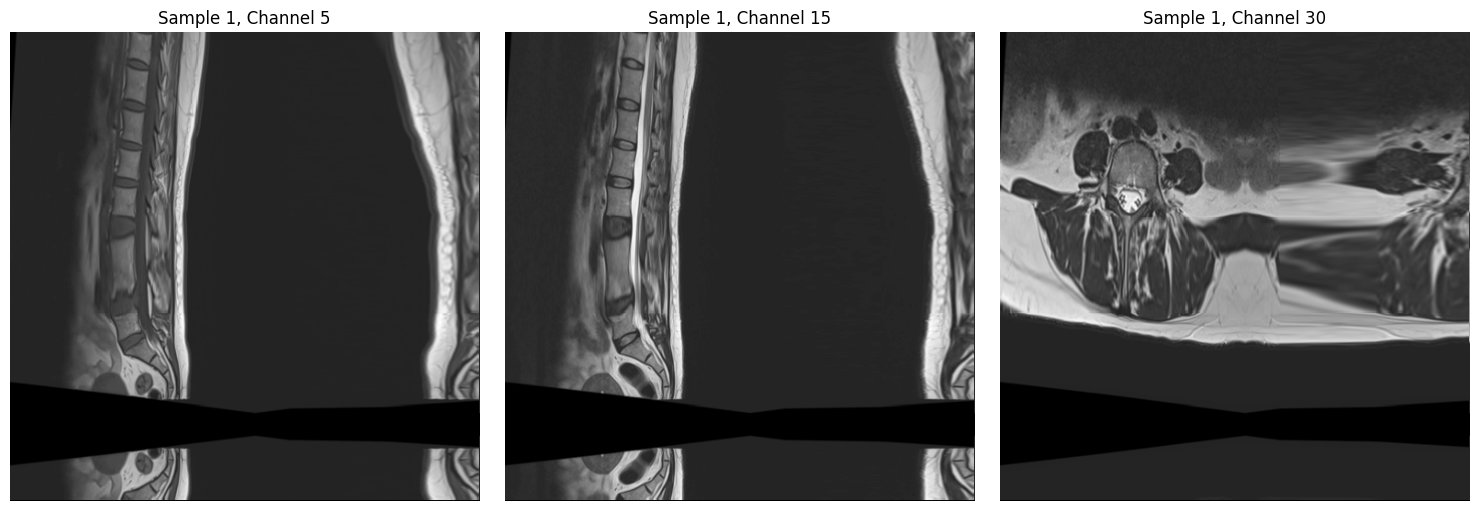

Channel 5 stats - Min: -1.00, Max: 0.89, Mean: -0.59, Std: 0.35
Channel 15 stats - Min: -1.00, Max: 0.84, Mean: -0.58, Std: 0.35
Channel 30 stats - Min: -1.00, Max: 0.87, Mean: -0.49, Std: 0.40

Sample 2:
Input tensor shape: torch.Size([1, 40, 512, 512])
Input tensor stats - Min: -1.00, Max: 1.00, Mean: -0.54, Std: 0.32
Target: tensor([[0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1,
         0]]), Shape: torch.Size([1, 25])


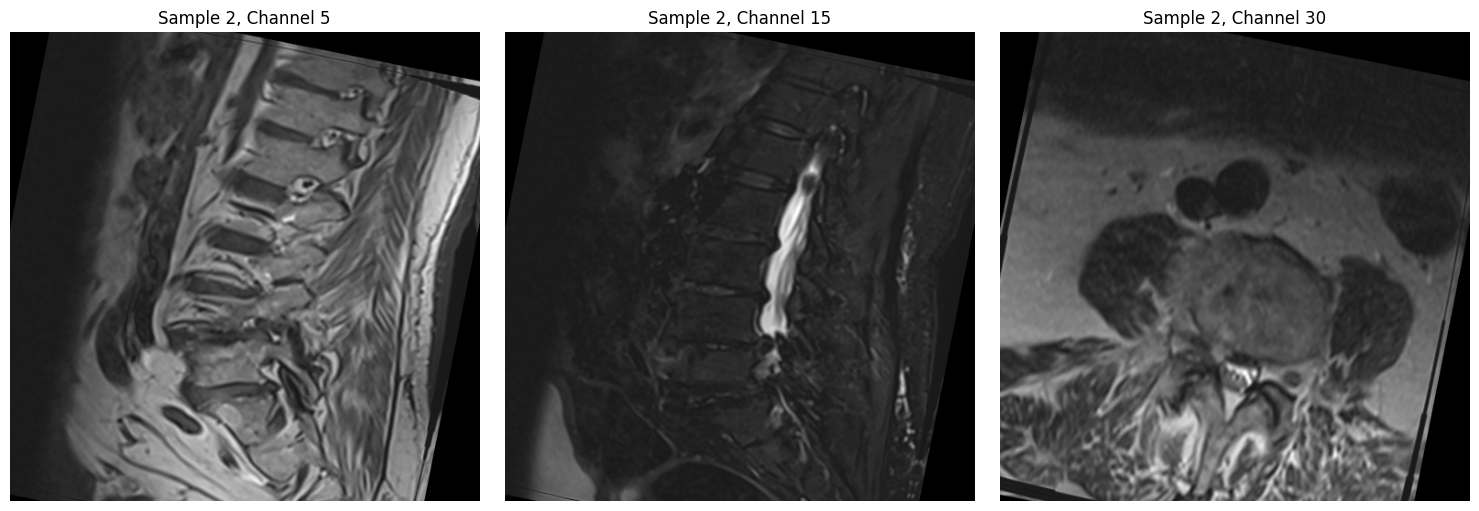

Channel 5 stats - Min: -1.00, Max: 0.99, Mean: -0.41, Std: 0.37
Channel 15 stats - Min: -1.00, Max: 0.99, Mean: -0.71, Std: 0.18
Channel 30 stats - Min: -1.00, Max: 0.98, Mean: -0.49, Std: 0.31



In [14]:
tmp_ds = RSNA24Dataset(df, phase='train', transform=transforms_train)
tmp_dl = DataLoader(
    tmp_ds,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
    num_workers=0
)

def display_channel(input_tensor, channel, title):
    channel_image = input_tensor[0, channel].numpy()
    channel_image = (channel_image - channel_image.min()) / (channel_image.max() - channel_image.min())
    plt.imshow(channel_image, cmap='gray')
    plt.title(title)
    plt.axis('off')

for i, (input_tensor, target) in enumerate(tmp_dl):
    if i == 2:
        break

    print(f"Sample {i+1}:")
    print(f"Input tensor shape: {input_tensor.shape}")
    print(f"Input tensor stats - Min: {input_tensor.min():.2f}, Max: {input_tensor.max():.2f}, Mean: {input_tensor.mean():.2f}, Std: {input_tensor.std():.2f}")
    print(f"Target: {target}, Shape: {target.shape}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    display_channel(input_tensor, 5, f"Sample {i+1}, Channel 5")

    plt.subplot(1, 3, 2)
    display_channel(input_tensor, 15, f"Sample {i+1}, Channel 15")

    plt.subplot(1, 3, 3)
    display_channel(input_tensor, 30, f"Sample {i+1}, Channel 30")

    plt.tight_layout()
    plt.show()

    print(f"Channel 5 stats - Min: {input_tensor[0, 5].min():.2f}, Max: {input_tensor[0, 5].max():.2f}, Mean: {input_tensor[0, 5].mean():.2f}, Std: {input_tensor[0, 5].std():.2f}")
    print(f"Channel 15 stats - Min: {input_tensor[0, 15].min():.2f}, Max: {input_tensor[0, 15].max():.2f}, Mean: {input_tensor[0, 15].mean():.2f}, Std: {input_tensor[0, 15].std():.2f}")
    print(f"Channel 30 stats - Min: {input_tensor[0, 30].min():.2f}, Max: {input_tensor[0, 30].max():.2f}, Mean: {input_tensor[0, 30].mean():.2f}, Std: {input_tensor[0, 30].std():.2f}")
    print()

plt.close()
del tmp_ds, tmp_dl

In [15]:
# class RSNA24Model(nn.Module):
#     def __init__(self, model_name, in_chans=40, num_classes=75, pretrained=True, features_only=False):
#         super().__init__()
#         self.model = timm.create_model(
#                                     model_name,
#                                     pretrained=pretrained,
#                                     features_only=features_only,
#                                     in_chans=in_chans,
#                                     num_classes=num_classes,
#                                     global_pool='avg'
#                                     )

#     def forward(self, x):
#         y = self.model(x)
#         return y

In [16]:
class ClassificationModule(nn.Module):
#     def __init__(self, in_channels, num_classes, hidden_dim=512):
#         super().__init__()
#         self.conv = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
#         self.bn = nn.BatchNorm2d(hidden_dim)
#         self.pool = nn.AdaptiveAvgPool2d(1)
#         self.fc = nn.Linear(hidden_dim, num_classes)

#     def forward(self, x):
#         x = torch.relu(self.bn(self.conv(x)))
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

    def __init__(self, in_channels, num_classes, hidden_dim=512):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_dim)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class RSNA24Model(nn.Module):
    def __init__(self, base_model_name, in_chans, num_classes, pretrained=True):
        super().__init__()
        self.base_model = timm.create_model(base_model_name, pretrained=pretrained, in_chans=in_chans, features_only=True)

        # Freeze/Update the base model
        for param in self.base_model.parameters():
            param.requires_grad = BASE_MODEL_GRADIENT_UPDATE

        # Get the number of output features from the last layer of the base model
        with torch.no_grad():
            dummy_input = torch.randn(1, in_chans, IMG_SIZE[0], IMG_SIZE[1])
            features = self.base_model(dummy_input)
            in_features = features[-1].shape[1]  # Use the last feature map

            # i.e., if features[-1].shape is (1, 512, 7, 7),
            # then features[-1].shape[1] would be 512.
            # we're feeding it into a conv layer, so we need in_channels only.

        # Add custom classification module
        self.classification_module = ClassificationModule(in_features, num_classes)

    def forward(self, x):
        features = self.base_model(x)
        output = self.classification_module(features[-1])  # Use the last feature map
        return output.view(output.size(0), -1)  # Reshape to (batch_size, num_classes * 3)

In [17]:
m = RSNA24Model(MODEL_NAME, in_chans=IN_CHANS, num_classes=N_CLASSES, pretrained=False)
i = torch.randn(2, IN_CHANS, IMG_SIZE[0], IMG_SIZE[1])
out = m(i)
for o in out:
    print(o.shape, o.min(), o.max())

del m, i, out

torch.Size([75]) tensor(-0.4611, grad_fn=<MinBackward1>) tensor(0.6823, grad_fn=<MaxBackward1>)
torch.Size([75]) tensor(-0.4432, grad_fn=<MinBackward1>) tensor(0.6565, grad_fn=<MaxBackward1>)


In [18]:
# Setup automatic mixed precision (AMP) for faster training and reduced memory usage
# autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.bfloat16) # for newer Ampere GPUs
autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # for T4 or newer GPUs

# Initialize gradient scaler for AMP
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=4096)

# Setup K-Fold cross-validation
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    print('#'*30)
    print(f'start fold{fold}')
    print('#'*30)
    print(len(trn_idx), len(val_idx))
    df_train = df.iloc[trn_idx]
    df_valid = df.iloc[val_idx]

    # Create training dataset and dataloader
    train_ds = RSNA24Dataset(df_train, phase='train', transform=transforms_train)
    train_dl = DataLoader(
                train_ds,
                batch_size=BATCH_SIZE,
                shuffle=True,
                pin_memory=True,
                drop_last=True,
                num_workers=N_WORKERS
                )

    # Create validation dataset and dataloader
    valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
    valid_dl = DataLoader(
                valid_ds,
                batch_size=BATCH_SIZE,
                shuffle=False,
                pin_memory=True,
                drop_last=False,
                num_workers=N_WORKERS
                )

    # Initialize the model
    model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=True)
    model.to(device)

    # Setup optimizer
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD)

    # Setup learning rate scheduler with warmup
    warmup_steps = EPOCHS/10 * len(train_dl) // GRAD_ACC
    num_total_steps = EPOCHS * len(train_dl) // GRAD_ACC
    num_cycles = 0.475
    scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                num_warmup_steps=warmup_steps,
                                                num_training_steps=num_total_steps,
                                                num_cycles=num_cycles)

    # Setup weighted loss function
    weights = torch.tensor([1.0, 2.0, 4.0])
    criterion = nn.CrossEntropyLoss(weight=weights.to(device))
    criterion2 = nn.CrossEntropyLoss(weight=weights)

    best_loss = math.log(N_CLASSES)
    best_wll = math.log(N_CLASSES)
    es_step = 0

    # Training loop
    for epoch in range(1, EPOCHS+1):
        print(f'start epoch {epoch}')
        model.train()
        total_loss = 0
        with tqdm(train_dl, leave=True) as pbar:
            optimizer.zero_grad()
            for idx, (x, t) in enumerate(pbar):
                x = x.to(device)
                t = t.to(device)

                with autocast:
                    loss = 0
                    y = model(x)
                    # Calculate loss for each label
                    for col in range(N_LABELS):
                        pred = y[:,col*3:col*3+3]
                        gt = t[:,col]
                        loss = loss + criterion(pred, gt) / N_LABELS

                    total_loss += loss.item()
                    if GRAD_ACC > 1:
                        loss = loss / GRAD_ACC

                # Check for NaN loss
                if not math.isfinite(loss):
                    print(f"Loss is {loss}, stopping training")
                    sys.exit(1)

                # Update progress bar
                pbar.set_postfix(
                    OrderedDict(
                        loss=f'{loss.item()*GRAD_ACC:.6f}',
                        lr=f'{optimizer.param_groups[0]["lr"]:.3e}'
                    )
                )
                # Backward pass with gradient scaling
                scaler.scale(loss).backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM or 1e9)

                # Gradient accumulation step
                if (idx + 1) % GRAD_ACC == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    if scheduler is not None:
                        scheduler.step()

        train_loss = total_loss/len(train_dl)
        print(f'train_loss:{train_loss:.6f}')

        # Validation loop
        total_loss = 0
        y_preds = []
        labels = []

        model.eval()
        with tqdm(valid_dl, leave=True) as pbar:
            with torch.no_grad():
                for idx, (x, t) in enumerate(pbar):

                    x = x.to(device)
                    t = t.to(device)

                    with autocast:
                        loss = 0
                        loss_ema = 0
                        y = model(x)
                        for col in range(N_LABELS):
                            pred = y[:,col*3:col*3+3]
                            gt = t[:,col]

                            loss = loss + criterion(pred, gt) / N_LABELS
                            y_pred = pred.float()
                            y_preds.append(y_pred.cpu())
                            labels.append(gt.cpu())

                        total_loss += loss.item()

        val_loss = total_loss/len(valid_dl)

        # Calculate validation metrics
        y_preds = torch.cat(y_preds, dim=0)
        labels = torch.cat(labels)
        val_wll = criterion2(y_preds, labels)

        print(f'val_loss:{val_loss:.6f}, val_wll:{val_wll:.6f}')

        # Save best model and update best scores
        if val_loss < best_loss or val_wll < best_wll:

            es_step = 0

            if device!='cuda:0':
                model.to('cuda:0')

            if val_loss < best_loss:
                print(f'epoch:{epoch}, best loss updated from {best_loss:.6f} to {val_loss:.6f}')
                best_loss = val_loss

            output_dir = f'{OUTPUT_PATH}/rsna-2024-lsdc-trained-models'
            os.makedirs(output_dir, exist_ok=True)

            if val_wll < best_wll:
                print(f'epoch:{epoch}, best wll_metric updated from {best_wll:.6f} to {val_wll:.6f}')
                best_wll = val_wll
                fname = os.path.join(output_dir, f'best_wll_model_fold-{fold}.pt')
                torch.save(model.state_dict(), fname)

            if device!='cuda:0':
                model.to(device)

        else:
            # Early stopping logic
            es_step += 1
            if es_step >= EARLY_STOPPING_EPOCH:
                print('early stopping')
                break

##############################
start fold0
##############################
1577 395


/tmp/ipykernel_24/2949222594.py:3: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # for T4 or newer GPUs
/tmp/ipykernel_24/2949222594.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=4096)


model.safetensors:   0%|          | 0.00/74.1M [00:00<?, ?B/s]

start epoch 1


100%|██████████| 98/98 [06:31<00:00,  4.00s/it, loss=0.865536, lr=1.959e-04]


train_loss:0.959606


100%|██████████| 25/25 [01:14<00:00,  2.97s/it]


val_loss:0.852281, val_wll:0.888494
epoch:1, best loss updated from 4.317488 to 0.852281
epoch:1, best wll_metric updated from 4.317488 to 0.888494
start epoch 2


100%|██████████| 98/98 [05:34<00:00,  3.42s/it, loss=0.747507, lr=3.959e-04]


train_loss:0.704136


100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


val_loss:0.698961, val_wll:0.742335
epoch:2, best loss updated from 0.852281 to 0.698961
epoch:2, best wll_metric updated from 0.888494 to 0.742335
start epoch 3


100%|██████████| 98/98 [05:56<00:00,  3.63s/it, loss=0.717690, lr=3.974e-04]


train_loss:0.660338


100%|██████████| 25/25 [00:54<00:00,  2.17s/it]


val_loss:0.737197, val_wll:0.784739
start epoch 4


100%|██████████| 98/98 [06:08<00:00,  3.76s/it, loss=0.646197, lr=3.893e-04]


train_loss:0.647379


100%|██████████| 25/25 [00:55<00:00,  2.21s/it]


val_loss:0.665520, val_wll:0.717693
epoch:4, best loss updated from 0.698961 to 0.665520
epoch:4, best wll_metric updated from 0.742335 to 0.717693
start epoch 5


100%|██████████| 98/98 [05:46<00:00,  3.54s/it, loss=0.689290, lr=3.761e-04]


train_loss:0.634268


100%|██████████| 25/25 [00:52<00:00,  2.10s/it]


val_loss:0.669519, val_wll:0.715948
epoch:5, best wll_metric updated from 0.717693 to 0.715948
start epoch 6


100%|██████████| 98/98 [05:52<00:00,  3.59s/it, loss=0.521769, lr=3.580e-04]


train_loss:0.616145


100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


val_loss:0.642198, val_wll:0.688215
epoch:6, best loss updated from 0.665520 to 0.642198
epoch:6, best wll_metric updated from 0.715948 to 0.688215
start epoch 7


100%|██████████| 98/98 [05:57<00:00,  3.65s/it, loss=0.737343, lr=3.356e-04]


train_loss:0.612457


100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


val_loss:0.624461, val_wll:0.668782
epoch:7, best loss updated from 0.642198 to 0.624461
epoch:7, best wll_metric updated from 0.688215 to 0.668782
start epoch 8


100%|██████████| 98/98 [05:48<00:00,  3.55s/it, loss=0.671802, lr=3.095e-04]


train_loss:0.604028


100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


val_loss:0.624250, val_wll:0.667822
epoch:8, best loss updated from 0.624461 to 0.624250
epoch:8, best wll_metric updated from 0.668782 to 0.667822
start epoch 9


100%|██████████| 98/98 [05:49<00:00,  3.56s/it, loss=0.494282, lr=2.804e-04]


train_loss:0.597899


100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


val_loss:0.619388, val_wll:0.665639
epoch:9, best loss updated from 0.624250 to 0.619388
epoch:9, best wll_metric updated from 0.667822 to 0.665639
start epoch 10


100%|██████████| 98/98 [05:45<00:00,  3.52s/it, loss=0.455378, lr=2.490e-04]


train_loss:0.590010


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


val_loss:0.625326, val_wll:0.673755
start epoch 11


100%|██████████| 98/98 [05:55<00:00,  3.62s/it, loss=0.478087, lr=2.164e-04]


train_loss:0.585907


100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


val_loss:0.609725, val_wll:0.654505
epoch:11, best loss updated from 0.619388 to 0.609725
epoch:11, best wll_metric updated from 0.665639 to 0.654505
start epoch 12


100%|██████████| 98/98 [05:56<00:00,  3.64s/it, loss=0.556508, lr=1.832e-04]


train_loss:0.573794


100%|██████████| 25/25 [00:53<00:00,  2.13s/it]


val_loss:0.611716, val_wll:0.653065
epoch:12, best wll_metric updated from 0.654505 to 0.653065
start epoch 13


100%|██████████| 98/98 [05:51<00:00,  3.59s/it, loss=0.608995, lr=1.506e-04]


train_loss:0.567422


100%|██████████| 25/25 [00:52<00:00,  2.10s/it]


val_loss:0.597673, val_wll:0.641956
epoch:13, best loss updated from 0.609725 to 0.597673
epoch:13, best wll_metric updated from 0.653065 to 0.641956
start epoch 14


100%|██████████| 98/98 [05:58<00:00,  3.66s/it, loss=0.478909, lr=1.193e-04]


train_loss:0.560372


100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


val_loss:0.594031, val_wll:0.637122
epoch:14, best loss updated from 0.597673 to 0.594031
epoch:14, best wll_metric updated from 0.641956 to 0.637122
start epoch 15


100%|██████████| 98/98 [05:46<00:00,  3.54s/it, loss=0.566995, lr=9.018e-05]


train_loss:0.551527


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


val_loss:0.593348, val_wll:0.636555
epoch:15, best loss updated from 0.594031 to 0.593348
epoch:15, best wll_metric updated from 0.637122 to 0.636555
start epoch 16


100%|██████████| 98/98 [06:33<00:00,  4.02s/it, loss=0.572724, lr=6.410e-05]


train_loss:0.545651


100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


val_loss:0.593417, val_wll:0.636828
start epoch 17


100%|██████████| 98/98 [05:51<00:00,  3.58s/it, loss=0.555175, lr=4.174e-05]


train_loss:0.536847


100%|██████████| 25/25 [00:55<00:00,  2.23s/it]


val_loss:0.590292, val_wll:0.633507
epoch:17, best loss updated from 0.593348 to 0.590292
epoch:17, best wll_metric updated from 0.636555 to 0.633507
start epoch 18


100%|██████████| 98/98 [05:54<00:00,  3.61s/it, loss=0.598367, lr=2.373e-05]


train_loss:0.528835


100%|██████████| 25/25 [00:51<00:00,  2.04s/it]


val_loss:0.587330, val_wll:0.629610
epoch:18, best loss updated from 0.590292 to 0.587330
epoch:18, best wll_metric updated from 0.633507 to 0.629610
start epoch 19


100%|██████████| 98/98 [05:51<00:00,  3.59s/it, loss=0.495193, lr=1.055e-05]


train_loss:0.525392


100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


val_loss:0.587704, val_wll:0.630156
start epoch 20


100%|██████████| 98/98 [06:06<00:00,  3.74s/it, loss=0.517191, lr=2.569e-06]


train_loss:0.524141


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


val_loss:0.585502, val_wll:0.626954
epoch:20, best loss updated from 0.587330 to 0.585502
epoch:20, best wll_metric updated from 0.629610 to 0.626954
##############################
start fold1
##############################
1577 395
start epoch 1


100%|██████████| 98/98 [06:17<00:00,  3.86s/it, loss=0.817779, lr=1.959e-04]


train_loss:0.962391


100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


val_loss:0.724139, val_wll:0.802370
epoch:1, best loss updated from 4.317488 to 0.724139
epoch:1, best wll_metric updated from 4.317488 to 0.802370
start epoch 2


100%|██████████| 98/98 [06:07<00:00,  3.76s/it, loss=0.614439, lr=3.959e-04]


train_loss:0.699516


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


val_loss:0.644076, val_wll:0.708827
epoch:2, best loss updated from 0.724139 to 0.644076
epoch:2, best wll_metric updated from 0.802370 to 0.708827
start epoch 3


100%|██████████| 98/98 [06:00<00:00,  3.68s/it, loss=0.645012, lr=3.974e-04]


train_loss:0.657985


100%|██████████| 25/25 [00:53<00:00,  2.14s/it]


val_loss:0.620923, val_wll:0.682325
epoch:3, best loss updated from 0.644076 to 0.620923
epoch:3, best wll_metric updated from 0.708827 to 0.682325
start epoch 4


100%|██████████| 98/98 [05:55<00:00,  3.62s/it, loss=0.509253, lr=3.893e-04]


train_loss:0.642228


100%|██████████| 25/25 [00:54<00:00,  2.17s/it]


val_loss:0.608449, val_wll:0.667433
epoch:4, best loss updated from 0.620923 to 0.608449
epoch:4, best wll_metric updated from 0.682325 to 0.667433
start epoch 5


100%|██████████| 98/98 [06:13<00:00,  3.81s/it, loss=0.623091, lr=3.761e-04]


train_loss:0.634365


100%|██████████| 25/25 [00:56<00:00,  2.24s/it]


val_loss:0.642090, val_wll:0.703914
start epoch 6


100%|██████████| 98/98 [06:06<00:00,  3.74s/it, loss=0.729973, lr=3.580e-04]


train_loss:0.627940


100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


val_loss:0.598834, val_wll:0.655013
epoch:6, best loss updated from 0.608449 to 0.598834
epoch:6, best wll_metric updated from 0.667433 to 0.655013
start epoch 7


100%|██████████| 98/98 [06:03<00:00,  3.71s/it, loss=0.541059, lr=3.356e-04]


train_loss:0.614406


100%|██████████| 25/25 [00:54<00:00,  2.18s/it]


val_loss:0.604802, val_wll:0.657146
start epoch 8


100%|██████████| 98/98 [05:50<00:00,  3.58s/it, loss=0.547793, lr=3.095e-04]


train_loss:0.613586


100%|██████████| 25/25 [00:52<00:00,  2.10s/it]


val_loss:0.603216, val_wll:0.662526
start epoch 9


100%|██████████| 98/98 [05:57<00:00,  3.64s/it, loss=0.548554, lr=2.804e-04]


train_loss:0.598661


100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


val_loss:0.596297, val_wll:0.654967
epoch:9, best loss updated from 0.598834 to 0.596297
epoch:9, best wll_metric updated from 0.655013 to 0.654967
start epoch 10


100%|██████████| 98/98 [05:47<00:00,  3.55s/it, loss=0.674347, lr=2.490e-04]


train_loss:0.595647


100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


val_loss:0.593357, val_wll:0.649275
epoch:10, best loss updated from 0.596297 to 0.593357
epoch:10, best wll_metric updated from 0.654967 to 0.649275
start epoch 11


100%|██████████| 98/98 [05:57<00:00,  3.65s/it, loss=0.684376, lr=2.164e-04]


train_loss:0.583510


100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


val_loss:0.584266, val_wll:0.640732
epoch:11, best loss updated from 0.593357 to 0.584266
epoch:11, best wll_metric updated from 0.649275 to 0.640732
start epoch 12


100%|██████████| 98/98 [05:46<00:00,  3.54s/it, loss=0.466358, lr=1.832e-04]


train_loss:0.573147


100%|██████████| 25/25 [00:52<00:00,  2.10s/it]


val_loss:0.591939, val_wll:0.651434
start epoch 13


100%|██████████| 98/98 [05:48<00:00,  3.56s/it, loss=0.646493, lr=1.506e-04]


train_loss:0.575070


100%|██████████| 25/25 [00:53<00:00,  2.14s/it]


val_loss:0.588192, val_wll:0.644852
start epoch 14


100%|██████████| 98/98 [05:46<00:00,  3.54s/it, loss=0.482621, lr=1.193e-04]


train_loss:0.567237


100%|██████████| 25/25 [00:55<00:00,  2.23s/it]


val_loss:0.582842, val_wll:0.637694
epoch:14, best loss updated from 0.584266 to 0.582842
epoch:14, best wll_metric updated from 0.640732 to 0.637694
start epoch 15


100%|██████████| 98/98 [05:58<00:00,  3.66s/it, loss=0.435276, lr=9.018e-05]


train_loss:0.555550


100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


val_loss:0.581893, val_wll:0.637261
epoch:15, best loss updated from 0.582842 to 0.581893
epoch:15, best wll_metric updated from 0.637694 to 0.637261
start epoch 16


100%|██████████| 98/98 [05:51<00:00,  3.59s/it, loss=0.531969, lr=6.410e-05]


train_loss:0.547399


100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


val_loss:0.576327, val_wll:0.630728
epoch:16, best loss updated from 0.581893 to 0.576327
epoch:16, best wll_metric updated from 0.637261 to 0.630728
start epoch 17


100%|██████████| 98/98 [06:00<00:00,  3.68s/it, loss=0.510360, lr=4.174e-05]


train_loss:0.539781


100%|██████████| 25/25 [00:52<00:00,  2.10s/it]


val_loss:0.576768, val_wll:0.630199
epoch:17, best wll_metric updated from 0.630728 to 0.630199
start epoch 18


100%|██████████| 98/98 [06:00<00:00,  3.68s/it, loss=0.496399, lr=2.373e-05]


train_loss:0.532909


100%|██████████| 25/25 [00:53<00:00,  2.12s/it]


val_loss:0.578794, val_wll:0.632276
start epoch 19


100%|██████████| 98/98 [05:48<00:00,  3.56s/it, loss=0.579459, lr=1.055e-05]


train_loss:0.533042


100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


val_loss:0.577790, val_wll:0.633664
start epoch 20


100%|██████████| 98/98 [06:03<00:00,  3.71s/it, loss=0.540042, lr=2.569e-06]


train_loss:0.528189


100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


val_loss:0.578858, val_wll:0.634135
early stopping
##############################
start fold2
##############################
1578 394
start epoch 1


100%|██████████| 98/98 [05:51<00:00,  3.59s/it, loss=0.696978, lr=1.959e-04]


train_loss:0.954390


100%|██████████| 25/25 [00:54<00:00,  2.20s/it]


val_loss:0.783645, val_wll:0.870069
epoch:1, best loss updated from 4.317488 to 0.783645
epoch:1, best wll_metric updated from 4.317488 to 0.870069
start epoch 2


100%|██████████| 98/98 [05:47<00:00,  3.55s/it, loss=0.773566, lr=3.959e-04]


train_loss:0.710685


100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


val_loss:0.657291, val_wll:0.715311
epoch:2, best loss updated from 0.783645 to 0.657291
epoch:2, best wll_metric updated from 0.870069 to 0.715311
start epoch 3


100%|██████████| 98/98 [05:44<00:00,  3.51s/it, loss=0.584351, lr=3.974e-04]


train_loss:0.661180


100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


val_loss:0.642586, val_wll:0.705094
epoch:3, best loss updated from 0.657291 to 0.642586
epoch:3, best wll_metric updated from 0.715311 to 0.705094
start epoch 4


100%|██████████| 98/98 [05:38<00:00,  3.45s/it, loss=0.584654, lr=3.893e-04]


train_loss:0.640313


100%|██████████| 25/25 [00:51<00:00,  2.08s/it]


val_loss:0.635161, val_wll:0.698582
epoch:4, best loss updated from 0.642586 to 0.635161
epoch:4, best wll_metric updated from 0.705094 to 0.698582
start epoch 5


100%|██████████| 98/98 [05:41<00:00,  3.49s/it, loss=0.612957, lr=3.761e-04]


train_loss:0.634617


100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


val_loss:0.614670, val_wll:0.673961
epoch:5, best loss updated from 0.635161 to 0.614670
epoch:5, best wll_metric updated from 0.698582 to 0.673961
start epoch 6


100%|██████████| 98/98 [05:43<00:00,  3.51s/it, loss=0.609290, lr=3.580e-04]


train_loss:0.626477


100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


val_loss:0.615074, val_wll:0.673466
epoch:6, best wll_metric updated from 0.673961 to 0.673466
start epoch 7


100%|██████████| 98/98 [05:44<00:00,  3.52s/it, loss=0.516251, lr=3.356e-04]


train_loss:0.617589


100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


val_loss:0.628504, val_wll:0.689198
start epoch 8


100%|██████████| 98/98 [05:44<00:00,  3.52s/it, loss=0.572669, lr=3.095e-04]


train_loss:0.603304


100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


val_loss:0.597714, val_wll:0.653049
epoch:8, best loss updated from 0.614670 to 0.597714
epoch:8, best wll_metric updated from 0.673466 to 0.653049
start epoch 9


100%|██████████| 98/98 [05:42<00:00,  3.50s/it, loss=0.672675, lr=2.804e-04]


train_loss:0.599930


100%|██████████| 25/25 [00:53<00:00,  2.13s/it]


val_loss:0.594282, val_wll:0.647809
epoch:9, best loss updated from 0.597714 to 0.594282
epoch:9, best wll_metric updated from 0.653049 to 0.647809
start epoch 10


100%|██████████| 98/98 [05:45<00:00,  3.52s/it, loss=0.578064, lr=2.490e-04]


train_loss:0.594413


100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


val_loss:0.598565, val_wll:0.657527
start epoch 11


100%|██████████| 98/98 [05:47<00:00,  3.54s/it, loss=0.654894, lr=2.164e-04]


train_loss:0.583304


100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


val_loss:0.592104, val_wll:0.647130
epoch:11, best loss updated from 0.594282 to 0.592104
epoch:11, best wll_metric updated from 0.647809 to 0.647130
start epoch 12


100%|██████████| 98/98 [05:39<00:00,  3.46s/it, loss=0.513248, lr=1.832e-04]


train_loss:0.581477


100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


val_loss:0.590475, val_wll:0.646395
epoch:12, best loss updated from 0.592104 to 0.590475
epoch:12, best wll_metric updated from 0.647130 to 0.646395
start epoch 13


100%|██████████| 98/98 [05:42<00:00,  3.49s/it, loss=0.667767, lr=1.506e-04]


train_loss:0.572635


100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


val_loss:0.590396, val_wll:0.645813
epoch:13, best loss updated from 0.590475 to 0.590396
epoch:13, best wll_metric updated from 0.646395 to 0.645813
start epoch 14


100%|██████████| 98/98 [05:36<00:00,  3.44s/it, loss=0.607893, lr=1.193e-04]


train_loss:0.565311


100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


val_loss:0.581249, val_wll:0.637681
epoch:14, best loss updated from 0.590396 to 0.581249
epoch:14, best wll_metric updated from 0.645813 to 0.637681
start epoch 15


100%|██████████| 98/98 [05:41<00:00,  3.49s/it, loss=0.509836, lr=9.018e-05]


train_loss:0.560634


100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


val_loss:0.576712, val_wll:0.631791
epoch:15, best loss updated from 0.581249 to 0.576712
epoch:15, best wll_metric updated from 0.637681 to 0.631791
start epoch 16


100%|██████████| 98/98 [05:43<00:00,  3.51s/it, loss=0.439195, lr=6.410e-05]


train_loss:0.551031


100%|██████████| 25/25 [00:52<00:00,  2.12s/it]


val_loss:0.568944, val_wll:0.624012
epoch:16, best loss updated from 0.576712 to 0.568944
epoch:16, best wll_metric updated from 0.631791 to 0.624012
start epoch 17


100%|██████████| 98/98 [05:54<00:00,  3.62s/it, loss=0.544063, lr=4.174e-05]


train_loss:0.541326


100%|██████████| 25/25 [00:52<00:00,  2.10s/it]


val_loss:0.567246, val_wll:0.621794
epoch:17, best loss updated from 0.568944 to 0.567246
epoch:17, best wll_metric updated from 0.624012 to 0.621794
start epoch 18


100%|██████████| 98/98 [05:46<00:00,  3.54s/it, loss=0.377477, lr=2.373e-05]


train_loss:0.534928


100%|██████████| 25/25 [00:52<00:00,  2.10s/it]


val_loss:0.565253, val_wll:0.617873
epoch:18, best loss updated from 0.567246 to 0.565253
epoch:18, best wll_metric updated from 0.621794 to 0.617873
start epoch 19


100%|██████████| 98/98 [05:43<00:00,  3.51s/it, loss=0.634561, lr=1.055e-05]


train_loss:0.531325


100%|██████████| 25/25 [00:56<00:00,  2.25s/it]


val_loss:0.565930, val_wll:0.620330
start epoch 20


100%|██████████| 98/98 [05:58<00:00,  3.66s/it, loss=0.572026, lr=2.569e-06]


train_loss:0.531448


100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


val_loss:0.565779, val_wll:0.618594
##############################
start fold3
##############################
1578 394
start epoch 1


100%|██████████| 98/98 [05:44<00:00,  3.52s/it, loss=0.769288, lr=1.959e-04]


train_loss:0.964508


100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


val_loss:0.729761, val_wll:0.788990
epoch:1, best loss updated from 4.317488 to 0.729761
epoch:1, best wll_metric updated from 4.317488 to 0.788990
start epoch 2


100%|██████████| 98/98 [05:52<00:00,  3.59s/it, loss=0.716258, lr=3.959e-04]


train_loss:0.715040


100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


val_loss:0.648177, val_wll:0.705959
epoch:2, best loss updated from 0.729761 to 0.648177
epoch:2, best wll_metric updated from 0.788990 to 0.705959
start epoch 3


100%|██████████| 98/98 [05:55<00:00,  3.63s/it, loss=0.724837, lr=3.974e-04]


train_loss:0.663242


100%|██████████| 25/25 [00:51<00:00,  2.08s/it]


val_loss:0.624179, val_wll:0.672732
epoch:3, best loss updated from 0.648177 to 0.624179
epoch:3, best wll_metric updated from 0.705959 to 0.672732
start epoch 4


100%|██████████| 98/98 [05:41<00:00,  3.49s/it, loss=0.634172, lr=3.893e-04]


train_loss:0.645568


100%|██████████| 25/25 [00:53<00:00,  2.14s/it]


val_loss:0.639399, val_wll:0.689202
start epoch 5


100%|██████████| 98/98 [06:00<00:00,  3.67s/it, loss=0.622233, lr=3.761e-04]


train_loss:0.632627


100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


val_loss:0.605940, val_wll:0.658078
epoch:5, best loss updated from 0.624179 to 0.605940
epoch:5, best wll_metric updated from 0.672732 to 0.658078
start epoch 6


100%|██████████| 98/98 [05:50<00:00,  3.58s/it, loss=0.478707, lr=3.580e-04]


train_loss:0.625778


100%|██████████| 25/25 [00:50<00:00,  2.02s/it]


val_loss:0.597404, val_wll:0.647208
epoch:6, best loss updated from 0.605940 to 0.597404
epoch:6, best wll_metric updated from 0.658078 to 0.647208
start epoch 7


100%|██████████| 98/98 [05:57<00:00,  3.65s/it, loss=0.549009, lr=3.356e-04]


train_loss:0.617193


100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


val_loss:0.589591, val_wll:0.644507
epoch:7, best loss updated from 0.597404 to 0.589591
epoch:7, best wll_metric updated from 0.647208 to 0.644507
start epoch 8


100%|██████████| 98/98 [05:43<00:00,  3.51s/it, loss=0.619866, lr=3.095e-04]


train_loss:0.608410


100%|██████████| 25/25 [00:52<00:00,  2.10s/it]


val_loss:0.584420, val_wll:0.631870
epoch:8, best loss updated from 0.589591 to 0.584420
epoch:8, best wll_metric updated from 0.644507 to 0.631870
start epoch 9


100%|██████████| 98/98 [05:51<00:00,  3.59s/it, loss=0.547510, lr=2.804e-04]


train_loss:0.601825


100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


val_loss:0.592357, val_wll:0.638516
start epoch 10


100%|██████████| 98/98 [05:56<00:00,  3.64s/it, loss=0.515863, lr=2.490e-04]


train_loss:0.597659


100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


val_loss:0.612184, val_wll:0.669705
start epoch 11


100%|██████████| 98/98 [05:47<00:00,  3.54s/it, loss=0.516147, lr=2.164e-04]


train_loss:0.583984


100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


val_loss:0.560151, val_wll:0.609302
epoch:11, best loss updated from 0.584420 to 0.560151
epoch:11, best wll_metric updated from 0.631870 to 0.609302
start epoch 12


100%|██████████| 98/98 [05:43<00:00,  3.50s/it, loss=0.610948, lr=1.832e-04]


train_loss:0.580585


100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


val_loss:0.566715, val_wll:0.618984
start epoch 13


100%|██████████| 98/98 [05:46<00:00,  3.54s/it, loss=0.508408, lr=1.506e-04]


train_loss:0.570239


100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


val_loss:0.561740, val_wll:0.611457
start epoch 14


100%|██████████| 98/98 [05:53<00:00,  3.61s/it, loss=0.465567, lr=1.193e-04]


train_loss:0.559360


100%|██████████| 25/25 [00:51<00:00,  2.08s/it]


val_loss:0.560284, val_wll:0.606028
epoch:14, best wll_metric updated from 0.609302 to 0.606028
start epoch 15


100%|██████████| 98/98 [05:48<00:00,  3.56s/it, loss=0.714443, lr=9.018e-05]


train_loss:0.551613


100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


val_loss:0.547492, val_wll:0.595687
epoch:15, best loss updated from 0.560151 to 0.547492
epoch:15, best wll_metric updated from 0.606028 to 0.595687
start epoch 16


100%|██████████| 98/98 [05:40<00:00,  3.47s/it, loss=0.443700, lr=6.410e-05]


train_loss:0.543715


100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


val_loss:0.550549, val_wll:0.597819
start epoch 17


100%|██████████| 98/98 [05:55<00:00,  3.62s/it, loss=0.555665, lr=4.174e-05]


train_loss:0.534313


100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


val_loss:0.547830, val_wll:0.594065
epoch:17, best wll_metric updated from 0.595687 to 0.594065
start epoch 18


100%|██████████| 98/98 [05:43<00:00,  3.50s/it, loss=0.514834, lr=2.373e-05]


train_loss:0.531018


100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


val_loss:0.548927, val_wll:0.595570
start epoch 19


100%|██████████| 98/98 [05:50<00:00,  3.58s/it, loss=0.579447, lr=1.055e-05]


train_loss:0.524654


100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


val_loss:0.548689, val_wll:0.595930
start epoch 20


100%|██████████| 98/98 [05:52<00:00,  3.60s/it, loss=0.537767, lr=2.569e-06]


train_loss:0.524149


100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


val_loss:0.549892, val_wll:0.598280
early stopping
##############################
start fold4
##############################
1578 394
start epoch 1


100%|██████████| 98/98 [05:49<00:00,  3.57s/it, loss=0.721515, lr=1.959e-04]


train_loss:0.940759


100%|██████████| 25/25 [00:50<00:00,  2.03s/it]


val_loss:0.731376, val_wll:0.794433
epoch:1, best loss updated from 4.317488 to 0.731376
epoch:1, best wll_metric updated from 4.317488 to 0.794433
start epoch 2


100%|██████████| 98/98 [05:47<00:00,  3.55s/it, loss=0.661452, lr=3.959e-04]


train_loss:0.701442


100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


val_loss:0.656940, val_wll:0.723425
epoch:2, best loss updated from 0.731376 to 0.656940
epoch:2, best wll_metric updated from 0.794433 to 0.723425
start epoch 3


100%|██████████| 98/98 [05:56<00:00,  3.63s/it, loss=0.645068, lr=3.974e-04]


train_loss:0.668540


100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


val_loss:0.666560, val_wll:0.724654
start epoch 4


100%|██████████| 98/98 [05:55<00:00,  3.63s/it, loss=0.709739, lr=3.893e-04]


train_loss:0.648557


100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


val_loss:0.635052, val_wll:0.698775
epoch:4, best loss updated from 0.656940 to 0.635052
epoch:4, best wll_metric updated from 0.723425 to 0.698775
start epoch 5


100%|██████████| 98/98 [05:53<00:00,  3.60s/it, loss=0.748189, lr=3.761e-04]


train_loss:0.630519


100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


val_loss:0.636079, val_wll:0.705524
start epoch 6


100%|██████████| 98/98 [05:49<00:00,  3.57s/it, loss=0.671963, lr=3.580e-04]


train_loss:0.623121


100%|██████████| 25/25 [00:50<00:00,  2.04s/it]


val_loss:0.620597, val_wll:0.679312
epoch:6, best loss updated from 0.635052 to 0.620597
epoch:6, best wll_metric updated from 0.698775 to 0.679312
start epoch 7


100%|██████████| 98/98 [05:46<00:00,  3.54s/it, loss=0.540871, lr=3.356e-04]


train_loss:0.614804


100%|██████████| 25/25 [00:53<00:00,  2.12s/it]


val_loss:0.621454, val_wll:0.677586
epoch:7, best wll_metric updated from 0.679312 to 0.677586
start epoch 8


100%|██████████| 98/98 [05:49<00:00,  3.56s/it, loss=0.568468, lr=3.095e-04]


train_loss:0.612741


100%|██████████| 25/25 [00:52<00:00,  2.12s/it]


val_loss:0.632600, val_wll:0.694842
start epoch 9


100%|██████████| 98/98 [05:50<00:00,  3.57s/it, loss=0.452147, lr=2.804e-04]


train_loss:0.598097


100%|██████████| 25/25 [00:50<00:00,  2.03s/it]


val_loss:0.600027, val_wll:0.661586
epoch:9, best loss updated from 0.620597 to 0.600027
epoch:9, best wll_metric updated from 0.677586 to 0.661586
start epoch 10


100%|██████████| 98/98 [05:53<00:00,  3.60s/it, loss=0.546936, lr=2.490e-04]


train_loss:0.593660


100%|██████████| 25/25 [00:52<00:00,  2.12s/it]


val_loss:0.613148, val_wll:0.678525
start epoch 11


100%|██████████| 98/98 [05:52<00:00,  3.59s/it, loss=0.667320, lr=2.164e-04]


train_loss:0.588555


100%|██████████| 25/25 [00:50<00:00,  2.04s/it]


val_loss:0.608329, val_wll:0.675760
start epoch 12


100%|██████████| 98/98 [05:54<00:00,  3.62s/it, loss=0.617701, lr=1.832e-04]


train_loss:0.574695


100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


val_loss:0.588897, val_wll:0.645882
epoch:12, best loss updated from 0.600027 to 0.588897
epoch:12, best wll_metric updated from 0.661586 to 0.645882
start epoch 13


100%|██████████| 98/98 [05:53<00:00,  3.60s/it, loss=0.494112, lr=1.506e-04]


train_loss:0.562131


100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


val_loss:0.596127, val_wll:0.657609
start epoch 14


100%|██████████| 98/98 [05:54<00:00,  3.61s/it, loss=0.584903, lr=1.193e-04]


train_loss:0.561368


100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


val_loss:0.581647, val_wll:0.637052
epoch:14, best loss updated from 0.588897 to 0.581647
epoch:14, best wll_metric updated from 0.645882 to 0.637052
start epoch 15


100%|██████████| 98/98 [05:55<00:00,  3.63s/it, loss=0.761970, lr=9.018e-05]


train_loss:0.548087


100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


val_loss:0.585013, val_wll:0.643960
start epoch 16


100%|██████████| 98/98 [05:59<00:00,  3.67s/it, loss=0.437578, lr=6.410e-05]


train_loss:0.539310


100%|██████████| 25/25 [00:51<00:00,  2.08s/it]


val_loss:0.570940, val_wll:0.627678
epoch:16, best loss updated from 0.581647 to 0.570940
epoch:16, best wll_metric updated from 0.637052 to 0.627678
start epoch 17


100%|██████████| 98/98 [05:54<00:00,  3.61s/it, loss=0.699638, lr=4.174e-05]


train_loss:0.537464


100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


val_loss:0.575332, val_wll:0.634922
start epoch 18


100%|██████████| 98/98 [05:52<00:00,  3.60s/it, loss=0.368245, lr=2.373e-05]


train_loss:0.526364


100%|██████████| 25/25 [00:51<00:00,  2.08s/it]


val_loss:0.578151, val_wll:0.638154
start epoch 19


100%|██████████| 98/98 [05:46<00:00,  3.54s/it, loss=0.440294, lr=1.055e-05]


train_loss:0.524811


100%|██████████| 25/25 [00:53<00:00,  2.12s/it]

val_loss:0.576668, val_wll:0.635392
early stopping


In [19]:
cv = 0
y_preds = []
labels = []
weights = torch.tensor([1.0, 2.0, 4.0])
criterion2 = nn.CrossEntropyLoss(weight=weights)

for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    print('#'*30)
    print(f'start fold{fold}')
    print('#'*30)
    df_valid = df.iloc[val_idx]
    valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
    valid_dl = DataLoader(
                valid_ds,
                batch_size=1,
                shuffle=False,
                pin_memory=True,
                drop_last=False,
                num_workers=N_WORKERS
                )

    model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=False)
    fname = f'{OUTPUT_PATH}/rsna-2024-lsdc-trained-models/best_wll_model_fold-{fold}.pt'
    model.load_state_dict(torch.load(fname))
    model.to(device)

    model.eval()
    with tqdm(valid_dl, leave=True) as pbar:
        with torch.no_grad():
            for idx, (x, t) in enumerate(pbar):

                x = x.to(device)
                t = t.to(device)

                with autocast:
                    y = model(x)
                    for col in range(N_LABELS):
                        pred = y[:,col*3:col*3+3]
                        gt = t[:,col]
                        y_pred = pred.float()
                        y_preds.append(y_pred.cpu())
                        labels.append(gt.cpu())

y_preds = torch.cat(y_preds)
labels = torch.cat(labels)

cv = criterion2(y_preds, labels)
print('cv score:', cv.item())

##############################
start fold0
##############################


/tmp/ipykernel_24/106066432.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fname))
100%|██████████| 395/395 [00:51<00:00,  7.68it/s]


##############################
start fold1
##############################


100%|██████████| 395/395 [00:51<00:00,  7.68it/s]


##############################
start fold2
##############################


100%|██████████| 394/394 [00:50<00:00,  7.75it/s]


##############################
start fold3
##############################


100%|██████████| 394/394 [00:51<00:00,  7.60it/s]


##############################
start fold4
##############################


100%|██████████| 394/394 [00:50<00:00,  7.79it/s]


cv score: 0.6194354891777039


In [20]:
from sklearn.metrics import log_loss
y_pred_np = y_preds.softmax(1).numpy()
labels_np = labels.numpy()
y_pred_nan = np.zeros((y_preds.shape[0], 1))
y_pred2 = np.concatenate([y_pred_nan, y_pred_np],axis=1)
weights = []
for l in labels:
    if l==0: weights.append(1)
    elif l==1: weights.append(2)
    elif l==2: weights.append(4)
    else: weights.append(0)
cv2 = log_loss(labels, y_pred2, normalize=True, sample_weight=weights)
print('cv score:', cv2)

cv score: 0.6194354693118327


In [21]:
np.save(f'{OUTPUT_PATH}/rsna-2024-lsdc-trained-models/labels.npy', labels_np)
np.save(f'{OUTPUT_PATH}/rsna-2024-lsdc-trained-models/final_oof.npy', y_pred2)